In [10]:
import os
import pandas as pd
import numpy as np
from PIL import Image, ImageOps, ImageFilter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
from PIL import Image, ImageFilter, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

## Preprocess Images

In [11]:
def preprocess_image(image, target_size, resize_image=True, blur_sigma=None, to_gray=True):
    # Apply Gaussian blur if sigma value is provided
    if blur_sigma is not None:
        image_blurred = image.filter(ImageFilter.GaussianBlur(blur_sigma))
    else:
        image_blurred = image
    
    if resize_image:
        # Resize image
        resized_image = image_blurred.resize(target_size, Image.LANCZOS)
    else:
        resized_image = image_blurred
    
    if to_gray:
        # Convert image to grayscale
        grayscale_image = resized_image.convert('L')
    else:
        grayscale_image = resized_image
    
    # Convert PIL image to numpy array and normalize
    image_processed = np.array(grayscale_image, dtype=np.float32) / 255.0
    
    return image_processed

## Read and create data set

In [12]:
BASE_DIR = '/kaggle/input/faceexp/dataset'

# Define preprocessing parameters
target_size = (64, 64)
threshold = 100
blur_sigma = 1.5

# Initialize an empty list to store preprocessed images and their corresponding emotions
data = {'preprocessed_image': [], 'emotion': []}

# Iterate over each folder in the dataset directory
for folder_name in os.listdir(BASE_DIR):
    folder_path = os.path.join(BASE_DIR, folder_name)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Extract emotion label from folder name
        emotion = folder_name
        
        # Iterate over each image file in the folder
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            
            # Load image
            image = Image.open(image_path)
            
            # Preprocess image
            preprocessed_image = preprocess_image(image, target_size,to_gray=False)
            
            # Append the preprocessed image and emotion to the data dictionary
            data['preprocessed_image'].append(preprocessed_image)
            data['emotion'].append(emotion)

# Create a DataFrame from the data dictionary
df_preprocessed = pd.DataFrame(data)

# Display the DataFrame
print(df_preprocessed)

                                      preprocessed_image   emotion
0      [[[0.5529412, 0.69803923, 0.9764706], [0.55686...  Surprise
1      [[[0.011764706, 0.011764706, 0.007843138], [0....  Surprise
2      [[[0.6039216, 0.74509805, 0.72156864], [0.6039...  Surprise
3      [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...  Surprise
4      [[[0.6862745, 0.7254902, 0.7058824], [0.772549...  Surprise
...                                                  ...       ...
15448  [[[0.8862745, 0.8784314, 0.83137256], [0.87450...    Ahegao
15449  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...    Ahegao
15450  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...    Ahegao
15451  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...    Ahegao
15452  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...    Ahegao

[15453 rows x 2 columns]


## Distribution of data

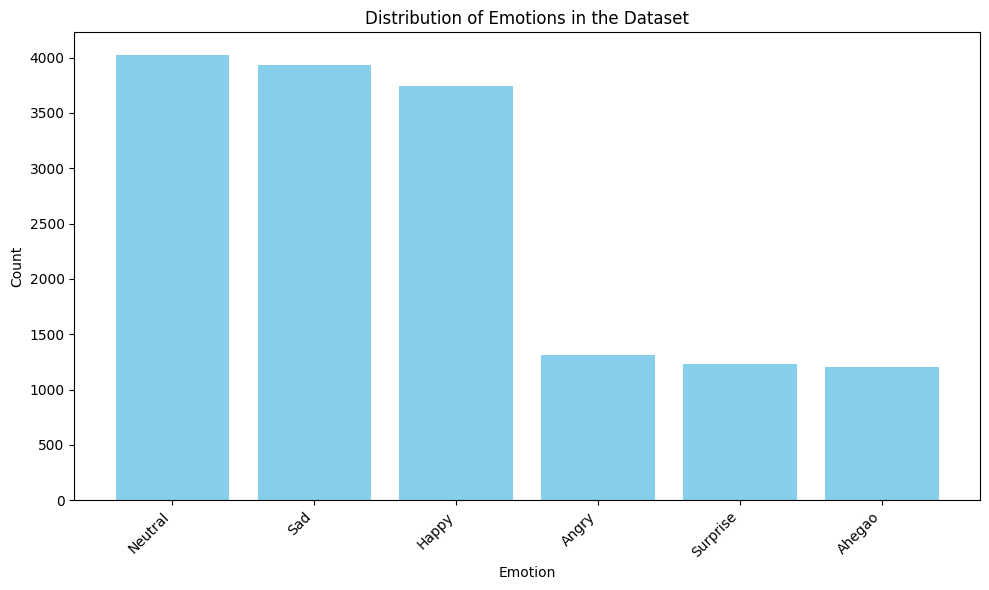

In [13]:
# Count the occurrences of each emotion in the dataset
emotion_counts = df_preprocessed['emotion'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(emotion_counts.index, emotion_counts.values, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions in the Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

## Create model

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB0  # Assuming you're using EfficientNetB0

num_classes = 6
# Load pre-trained EfficientNet model without including top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers so they are not trainable
base_model.trainable = False

# Add additional layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Add a dense layer
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation for multi-class classification

# Combine base model and additional layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 32, 32,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 32, 32,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 32, 32,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 32, 32,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 32, 32,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 32, 32,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 32, 32,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 32, 32,    │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 32, 32,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      1,536 │ block1a_project_… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b

 Total params: 4,379,042 (16.70 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 4,049,564 (15.45 MB)

## Train the model

In [15]:
from tensorflow.keras.utils import to_categorical
# Encode labels
label_encoder = LabelEncoder()
# Prepare data for training
X = np.array(df_preprocessed['preprocessed_image'].tolist())

y = label_encoder.fit_transform(df_preprocessed['emotion'])
# Reshape X to fit CNN input shape
X = X.reshape(-1, 64, 64,3)


# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_one_hot = to_categorical(y, num_classes=num_classes)


# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, shuffle=True)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/100
 10/194 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2125 - loss: 1.8239

I0000 00:00:1712090251.479988      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


194/194 ━━━━━━━━━━━━━━━━━━━━ 60s 161ms/step - accuracy: 0.3864 - loss: 1.4842 - val_accuracy: 0.4995 - val_loss: 1.2277
Epoch 2/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4857 - loss: 1.2722 - val_accuracy: 0.5199 - val_loss: 1.1921
Epoch 3/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5301 - loss: 1.1995 - val_accuracy: 0.5260 - val_loss: 1.1587
Epoch 4/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5249 - loss: 1.1857 - val_accuracy: 0.5393 - val_loss: 1.1405
Epoch 5/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5380 - loss: 1.1438 - val_accuracy: 0.5144 - val_loss: 1.1553
Epoch 6/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5454 - loss: 1.1335 - val_accuracy: 0.5387 - val_loss: 1.1171
Epoch 7/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5531 - loss: 1.1187 - val_accuracy: 0.5092 - val_loss: 1.1668
Epoch 8/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5595 - loss: 1.1094 - val_accura

## Evaluate the model

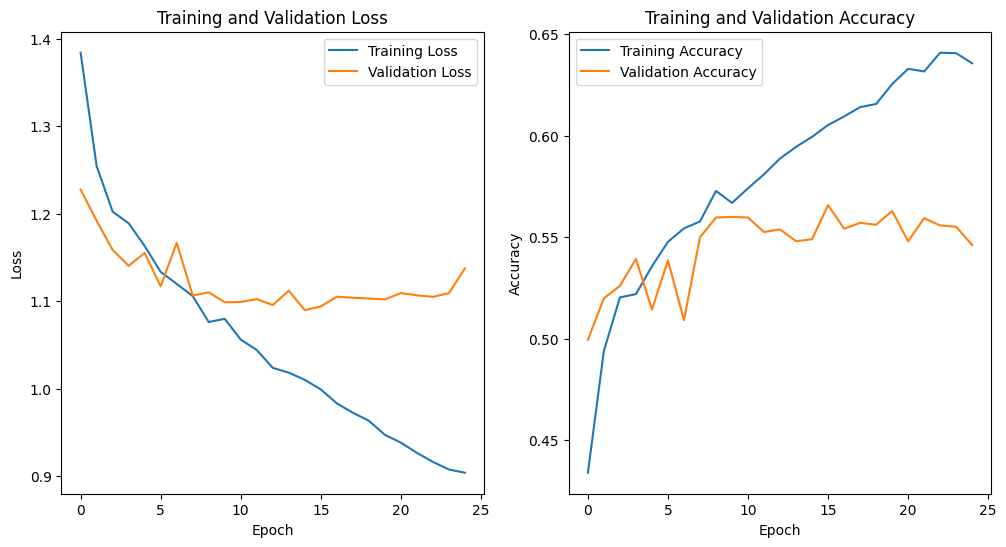

In [16]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step
Confusion Matrix:
[[178   0  11  14  11  14]
 [  3  60  31  61  86  16]
 [ 13   8 464 135  93  23]
 [ 14  24 108 458 206  37]
 [ 10  27 111 201 408  21]
 [ 23   2  29  32  30 129]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       228
           1       0.50      0.23      0.32       257
           2       0.62      0.63      0.62       736
           3       0.51      0.54      0.52       847
           4       0.49      0.52      0.51       778
           5       0.54      0.53      0.53       245

    accuracy                           0.55      3091
   macro avg       0.56      0.54      0.54      3091
weighted avg       0.55      0.55      0.54      3091



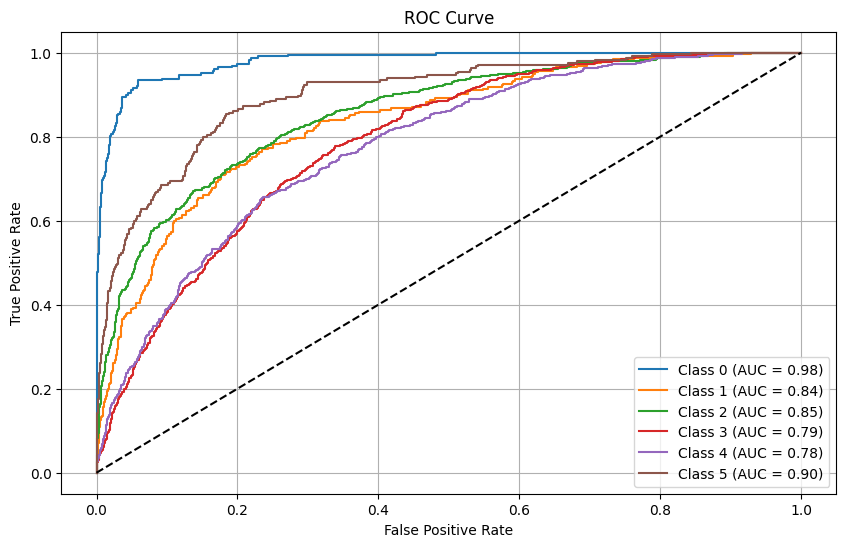

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Get model predictions for validation set
y_val_pred = model.predict(X_val)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val.argmax(axis=1), y_val_pred.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_val.argmax(axis=1), y_val_pred.argmax(axis=1))
print("\nClassification Report:")
print(class_report)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Predict random 50 images

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step 


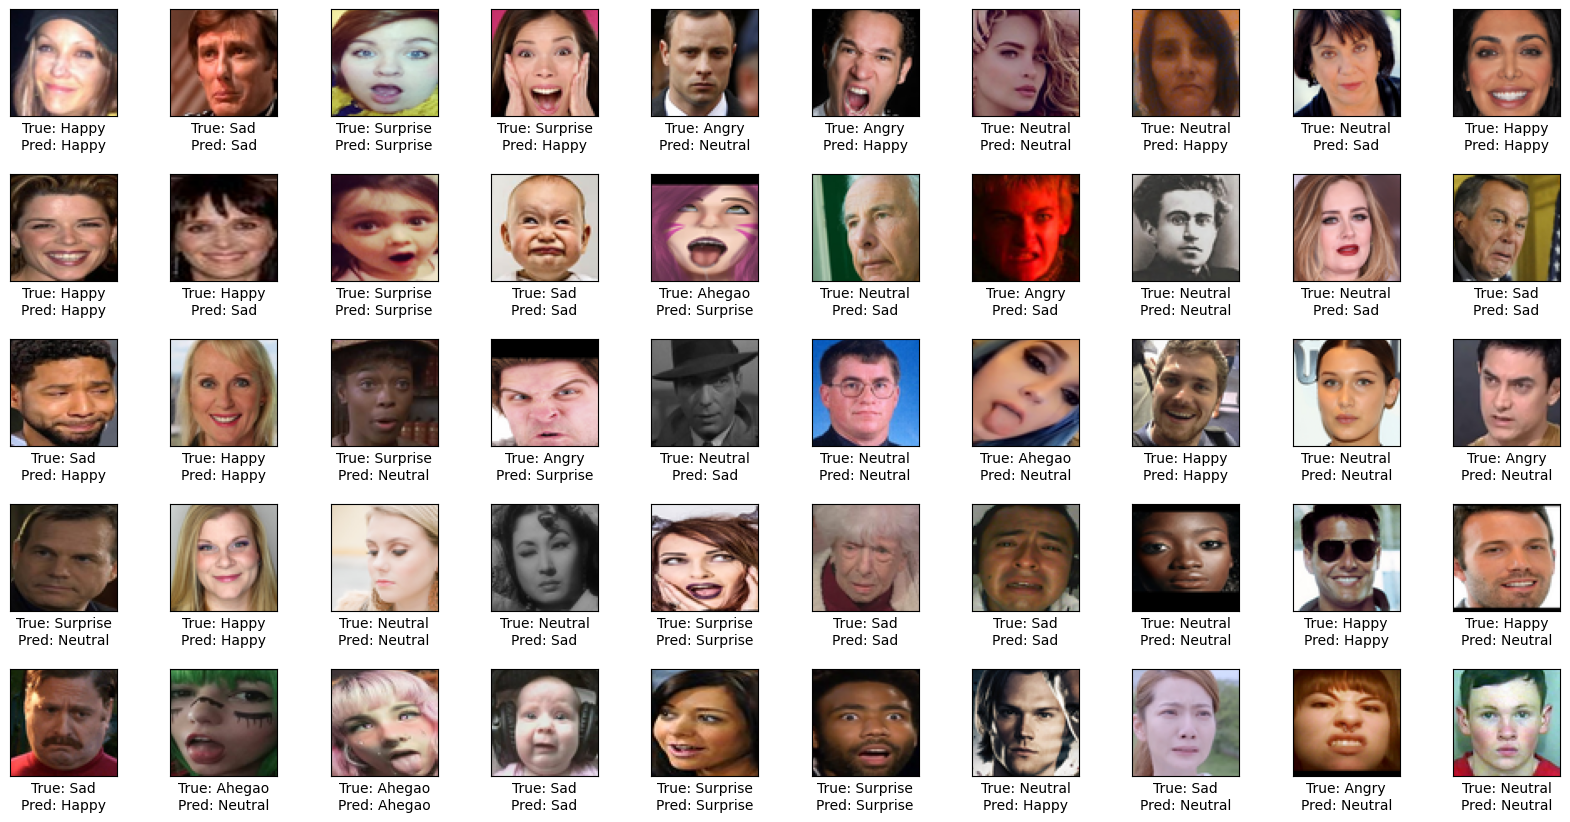

In [21]:
# Select 50 random images from the validation set
num_images = 50
random_indices = np.random.choice(len(X_val), num_images, replace=False)
sample_images = X_val[random_indices]
sample_labels = y_val[random_indices]

# Make predictions for the sample images
predictions = model.predict(sample_images)

# Decode one-hot encoded labels back to original labels
decoded_labels = label_encoder.inverse_transform(np.argmax(sample_labels, axis=1))

# Decode one-hot encoded predictions back to original labels
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Define a function to display images
def display_images(images, true_labels, predicted_labels):
    fig, axes = plt.subplots(5, 10, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}", fontsize=10)
    plt.show()

# Display the images
display_images(sample_images, decoded_labels, decoded_predictions)